# ctdproc: Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import ctdproc as ctd

plt.ion()

%config InlineBackend.figure_format = 'retina'

xr.set_options(display_style="text");

In [2]:
pd.options.display.html.table_schema = True

Path to example CTD file in .hex format. The corresponding xmlcon file needs to be in the same directory.

In [3]:
hexfile = Path('../ctdproc/tests/data/BLT_Test_001.hex')

Convert hex file

In [4]:
%%time
c = ctd.io.CTDHex(hexfile)

CPU times: user 2.79 s, sys: 48.1 ms, total: 2.84 s
Wall time: 2.84 s


Display parameters as read from xmlcon file. The parameters come in a `pandas.DataFrame`.

In [5]:
c.cfgp.transpose()

,@index,@SensorID,cal
TemperatureSensor1,0,55,"{'@SensorID': '55', 'SerialNumber': '2322', 'C..."
ConductivitySensor1,1,3,"{'@SensorID': '3', 'SerialNumber': '2569', 'Ca..."
PressureSensor,2,45,"{'@SensorID': '45', 'SerialNumber': '1316', 'C..."
TemperatureSensor2,3,55,"{'@SensorID': '55', 'SerialNumber': '6142', 'C..."
ConductivitySensor2,4,3,"{'@SensorID': '3', 'SerialNumber': '3207', 'Ca..."
FluoroSeapointSensor,5,11,"{'@SensorID': '11', 'SerialNumber': 'SCF2956',..."
PAR_BiosphericalLicorChelseaSensor,6,42,"{'@SensorID': '42', 'SerialNumber': '4542', 'C..."
WET_LabsCStar,7,71,"{'@SensorID': '71', 'SerialNumber': 'CST-1874D..."
AltimeterSensor,9,0,"{'@SensorID': '0', 'SerialNumber': 'N/A', 'Cal..."
OxygenSensor1,11,38,"{'@SensorID': '38', 'SerialNumber': '0255', 'C..."


Convert the data to an `xarray.Dataset`.

In [6]:
cx = c.to_xarray()

Display the Dataset.

In [7]:
cx

<xarray.Dataset> Size: 13MB
Dimensions:   (time: 120643)
Coordinates:
  * time      (time) datetime64[ns] 965kB 2019-11-06T18:20:31.000002 ... 2019...
Data variables:
    lon       (time) float64 965kB -117.5 -117.5 -117.5 ... -117.5 -117.5 -117.5
    lat       (time) float64 965kB 32.62 32.62 32.62 32.62 ... 32.62 32.62 32.62
    p         (time) float64 965kB 2.121 2.156 2.184 2.127 ... 1.572 1.551 1.551
    t1        (time) float64 965kB 17.76 17.79 17.83 17.88 ... 18.48 18.47 18.46
    t2        (time) float64 965kB 17.96 17.95 17.95 17.94 ... 18.51 18.52 18.52
    c1        (time) float64 965kB 4.406 4.41 4.415 4.421 ... 4.477 4.475 4.475
    c2        (time) float64 965kB 4.421 4.422 4.421 4.42 ... 4.482 4.482 4.482
    alt       (time) float64 965kB 74.73 74.73 74.73 74.73 ... 74.58 74.58 74.58
    fl        (time) float64 965kB 0.1062 0.1074 0.1074 ... 0.0293 0.03053
    trans     (time) float64 965kB 92.04 92.04 92.04 92.04 ... 96.79 96.79 96.79
    par       (time) float64 965kB 1.175e+03 1.178e+03 ... 4.531e+03 4.531e+03
    modcount  (time) int64 965kB 63 64 65 66 67 68 ... 124 125 126 127 128 129

Save time series to netcdf.

In [8]:
cx.to_netcdf("test.nc")

# Alternatively, save with time in cf-compliant format.
# Note that xarray complains if not setting `dtype` to float,
# however, this will create small changes at sub-microsecond precision
# cx.to_netcdf(
#     "test.nc", encoding={"time": {"units": "seconds since 1970-01-01", "dtype": float}}
# )

Save time series as Matlab file.

In [9]:
c.to_mat('./test.mat')

Plot time series from temperature sensor 1

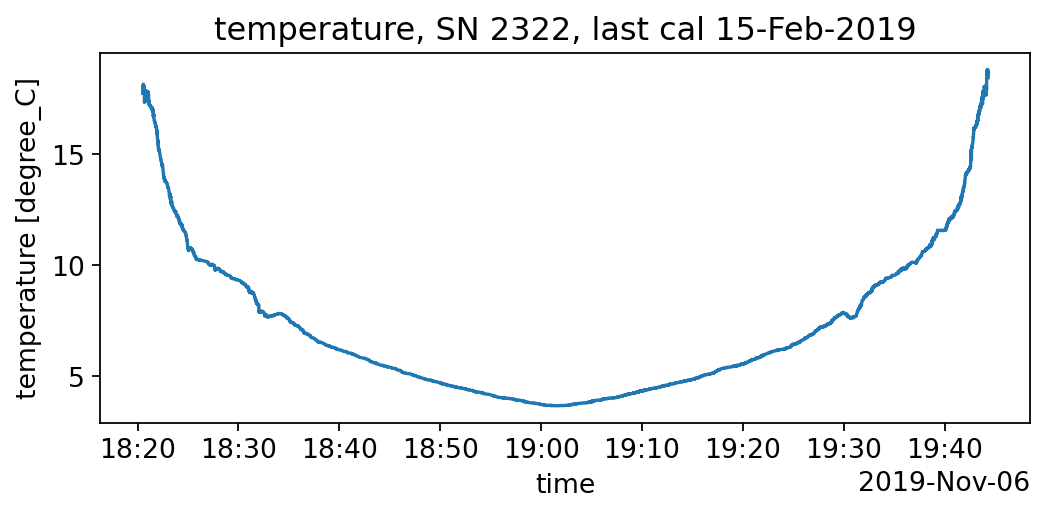

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 3))
cx.t1.plot(ax=ax)
ax.set(
    title="{}, SN {}, last cal {}".format(
        cx.t1.attrs["long_name"], cx.t1.attrs["serial_number"], cx.t1.attrs["calibration_date"]
    )
);

Plot more time series. Adjust automatic axis labels to fit everything.

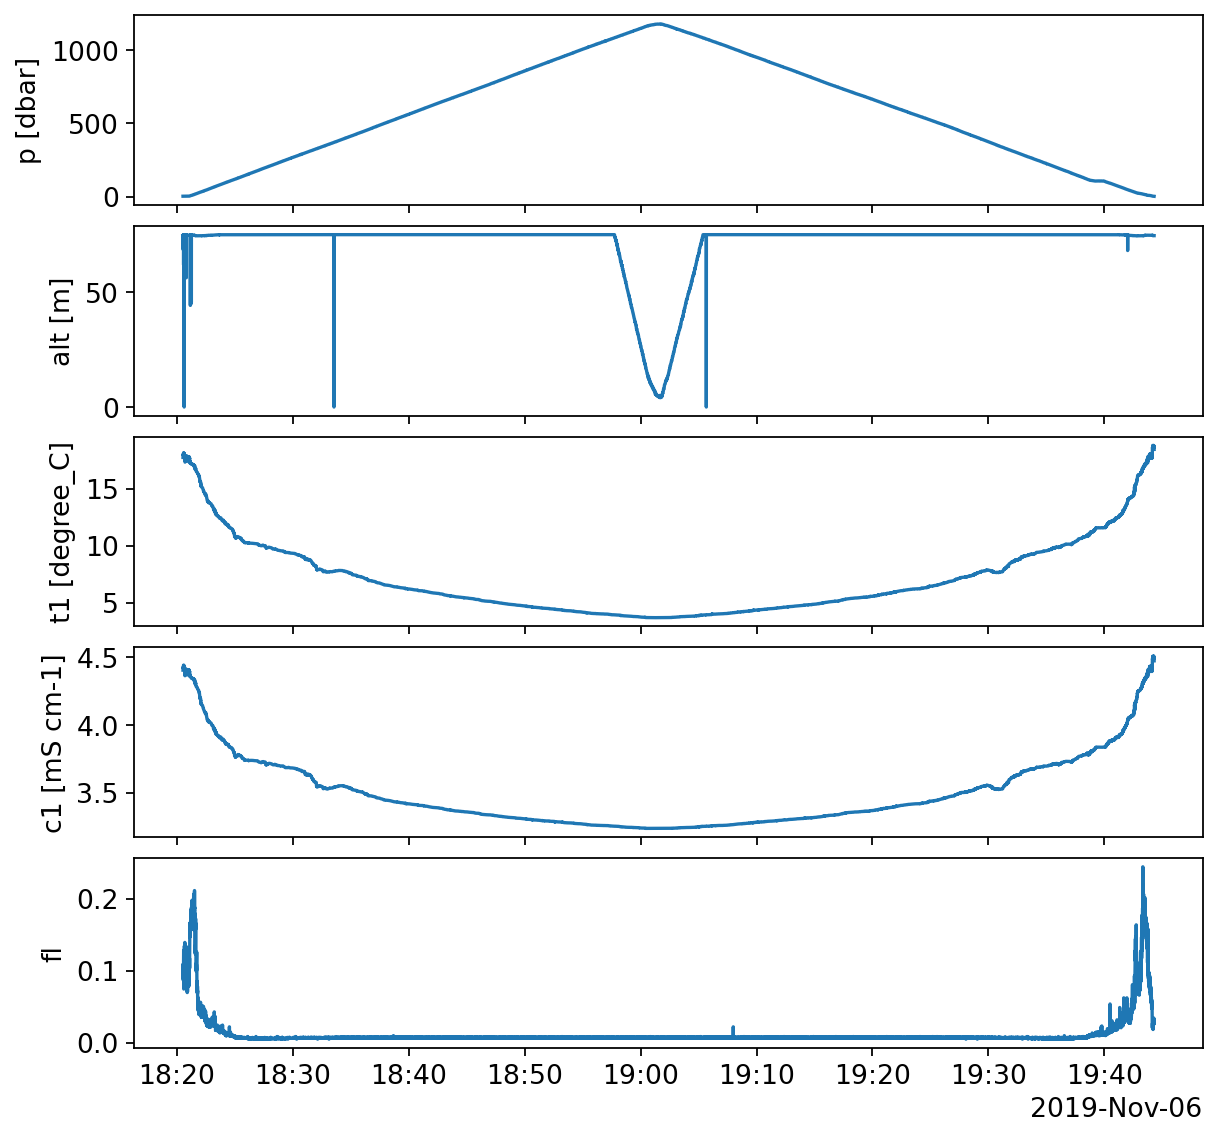

In [11]:
plot_vars = ["p", "alt", "t1", "c1", "fl"]
fig, ax = plt.subplots(
    nrows=len(plot_vars),
    ncols=1,
    figsize=(7.5, 7),
    constrained_layout=True,
    sharex=True,
)
for axi, vi in zip(ax, plot_vars):

    cx[vi].plot(ax=axi)
    if "units" in cx[vi].attrs:
        axi.set(ylabel=f"{vi:s} [{cx[vi].attrs['units']:s}]", xlabel="")
    else:
        axi.set(ylabel=f"{vi:s}", xlabel="")

Plot location data.

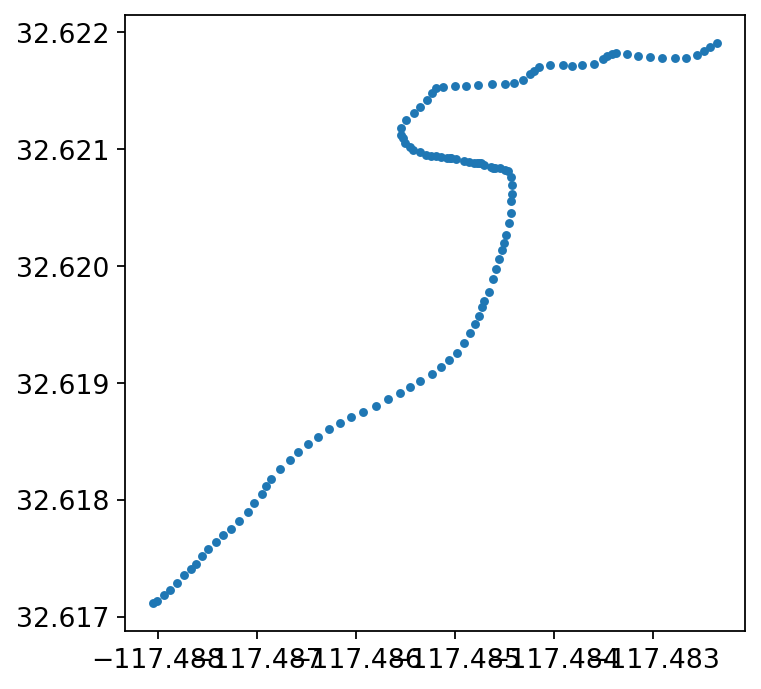

In [12]:
cxc = cx.coarsen(time=1000, boundary='trim').mean()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.plot(cxc.lon, cxc.lat, marker='.', linestyle='');

Run further processing steps on the time series.

In [13]:
ctd.io.add_default_proc_params(cx)

In [14]:
%%time
cx_ud = ctd.proc.run_all(cx)

1: tau = 0.0501s, lag = -0.0044s
2: tau = 0.0720s, lag = -0.0079s


/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(
/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(


1: tau = 0.0502s, lag = -0.0048s
2: tau = 0.0756s, lag = -0.0080s


/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(
/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(
/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(
/Users/gunnar/Projects/python/ctdproc/ctdproc/helpers.py:114: RuntimeWarning: no interpolation at start
  warnings.warn(


CPU times: user 6.35 s, sys: 103 ms, total: 6.46 s
Wall time: 6.42 s


Depth binning.

In [15]:
%%time
dz = 1
zmin = 10
zmax = np.ceil(cx_ud['down'].depth.max().data)
datad = ctd.proc.bincast(cx_ud['down'], dz, zmin, zmax)
datau = ctd.proc.bincast(cx_ud['up'], dz, zmin, zmax)

CPU times: user 8.73 s, sys: 59.2 ms, total: 8.79 s
Wall time: 9.15 s


Final data structure.

In [16]:
datad

<xarray.Dataset> Size: 213kB
Dimensions:  (depth: 1156)
Coordinates:
  * depth    (depth) float64 9kB 10.0 11.0 12.0 ... 1.164e+03 1.165e+03
    lon      (depth) float64 9kB -117.5 -117.5 -117.5 ... -117.5 -117.5 nan
    lat      (depth) float64 9kB 32.62 32.62 32.62 32.62 ... 32.62 32.62 nan
    time     (depth) datetime64[ns] 9kB 2019-11-06T18:21:21.062499887 ... NaT
Data variables: (12/19)
    t1       (depth) float64 9kB 17.13 17.1 17.09 17.03 ... 3.674 3.673 nan
    t2       (depth) float64 9kB 17.13 17.1 17.09 17.04 ... 3.676 3.675 nan
    c1       (depth) float64 9kB 4.343 4.341 4.339 4.334 ... 3.237 3.237 nan
    c2       (depth) float64 9kB 4.344 4.341 4.34 4.335 ... 3.237 3.237 nan
    p        (depth) float64 9kB 10.07 11.08 12.09 ... 1.175e+03 1.176e+03 nan
    trans    (depth) float64 9kB 89.54 89.91 90.47 90.86 ... 102.1 102.1 nan
    ...       ...
    CT1      (depth) float64 9kB 17.15 17.13 17.12 17.06 ... 3.588 3.588 nan
    CT2      (depth) float64 9kB 17.16 17.13 17.12 17.07 ... 3.59 3.589 nan
    th1      (depth) float64 9kB 17.12 17.1 17.09 17.03 ... 3.586 3.586 nan
    th2      (depth) float64 9kB 17.13 17.1 17.08 17.03 ... 3.59 3.588 3.587 nan
    sg1      (depth) float64 9kB 24.43 24.43 24.43 24.45 ... 27.45 27.45 nan
    sg2      (depth) float64 9kB 24.43 24.43 24.44 24.45 ... 27.45 27.45 nan
Attributes: (12/19)
    verbose:         1
    bounds_p:        [0.0, 6200.0]
    bounds_t:        [-2.0, 40.0]
    bounds_c:        [2.0, 6.0]
    bounds_s:        [20, 38]
    spike_thresh_t:  0.5
    ...              ...
    diff_s:          0.001
    diff_p:          2.0
    wthresh:         0.1
    plot_spectra:    0
    plot_path:       
    tcfit:           [500, np.float64(1177.701664126486)]

Plot potential density anomaly profile and its difference between the two sensors.

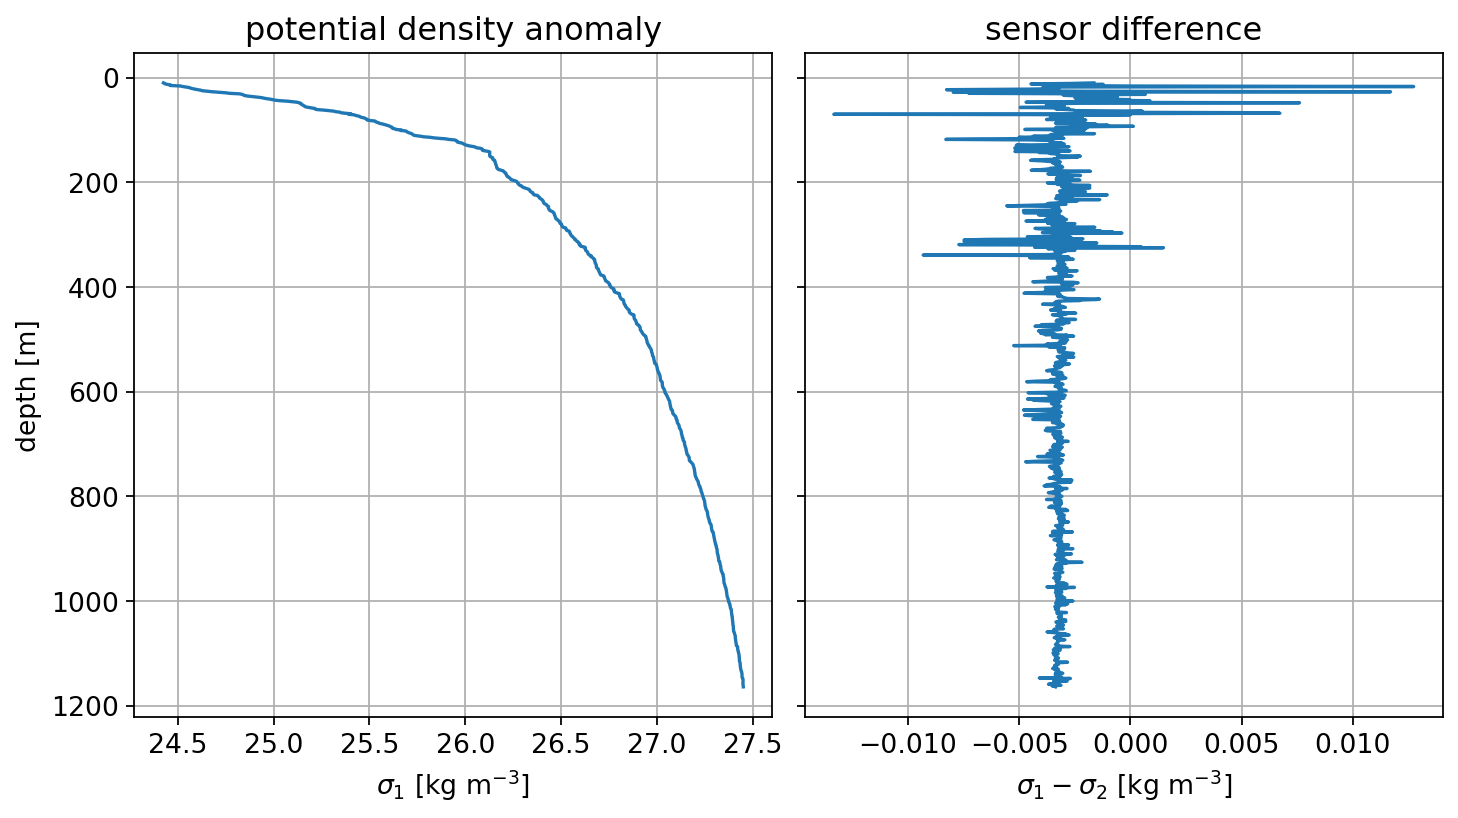

In [17]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(9, 5), constrained_layout=True, sharey=True
)
datad.sg1.plot(y="depth", yincrease=False, ax=ax[0])
ax[0].set(title="potential density anomaly", xlabel="$\sigma_1$ [kg m$^{-3}$]")
(datad.sg1 - datad.sg2).plot(y="depth", yincrease=False, ax=ax[1])
ax[1].set(title="sensor difference", ylabel="", xlabel="$\sigma_1-\sigma_2$ [kg m$^{-3}$]")
for axi in ax:
    axi.grid(True)